In [4]:
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import os, sys
from skimage.color import gray2rgb
from skimage.transform import resize
# from tf.image import resize, gray2rgb
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import re                               # regular expression: is a special sequence of characters that helps you 
                                        # match or find other strings or sets of strings
import numpy                            # Python package used for scientific computing. Contains a powerful n-dim array object
import matplotlib.pyplot as plt         # matplotlib for plotting graphs
%matplotlib inline
from random import randint              # Using the random module, we can generate pseudo-random numbers. 
                                        # The function random() generates a random number between zero and one 
                                        # [0, 0.1 .. 1].
from glob import glob                   # finds all the pathnames matching a specified patter
import pandas as pd                     # Python package providing fast, flexible, and expressive data structures 
                                        # designed to make working with “relational” or “labeled” data. 
                                        # Its a fundamental high-level building block for doing practical, real world
                                        # data analysis in Python.

print(tf.__version__)

image_size = (224,224)
batch_size = 32
#epochs = 500

# zip_path = '/content/drive/MyDrive/mias-dataset.zip'
datadir = '/mnt/c/Users/user/Desktop/mias-dataset/mias-dataset/'

from statistics import mean

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-01-04 12:13:18.827234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 12:13:19.296254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64
2023-01-04 12:13:19.296317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/inclu

2.11.0
Num GPUs Available:  1


2023-01-04 12:13:19.989968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 12:13:19.996442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-04 12:13:19.996481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# !rm -rf mias-dataset
# !unzip /content/drive/MyDrive/mias-dataset.zip -d /content/


In [7]:
class_name = ['Benign','Malignant']

In [39]:
def read_pgm(filename, byteorder='>'):                     # '>' indicates big-endian
  """Return image data from a raw PGM file as a numpy array.

  Format specification: http://netpbm.sourceforge.net/doc/pgm.html

  """

  with open(filename, 'rb') as f:
    buffer = f.read()
  try:
    header, width, height, maxval = re.search(  
    b"(^P5\s(?:\s*#.*[\r\n])*"                             # A pgm image's magic number is the two characters "P5"
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A width, formatted as ASCII characters in decimal
    b"(\d+)\s(?:\s*#.*[\r\n])*"                            # A height, again in ASCII decimal
    b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()       # The maximum gray value (Maxval), again in ASCII decimal. 
                                                           # Must be less than 65536, and more than zero.
  except AttributeError:
    raise ValueError("Not a raw PGM file: '%s'" % filename)
    
  return numpy.frombuffer(buffer,
               dtype='u1' if int(maxval) < 256 else byteorder+'u2',
               count=int(width)*int(height),
               offset=len(header)
              ).reshape((int(height)*int(width)))

def import_images(image_dir, num_images):
    
  # Create an array to hold all of the images, each of which is 1024x1024
  images_tensor = numpy.zeros((num_images, 1024*1024))
  # Create a tensor for the labels
  labels_tensor = numpy.zeros((num_images, 2))
    
  i = 0
  # if (image_dir.split('/')[-2] == 'normal'): 
  #   category = [1,0,0]
  if (image_dir.split('/')[-2] == 'benign'): 
    category = [1,0]
  elif (image_dir.split('/')[-2] == 'malignant'): 
    category = [0,1]
    
  for dirName, subdirList, fileList in os.walk(image_dir):
    for fname in fileList:
        if fname.endswith(".pgm") and i<num_images:
          images_tensor[i] = read_pgm(image_dir+fname, byteorder='<')
          labels_tensor[i] = fname[3:5]
          i+=1

  return images_tensor, labels_tensor


In [40]:
def split_dataset(dir,normal_img, benign_img, malignant_img):
  i=0;n=0;b=0;m=0
  # n_set=int(207*subset);b_set=int(63*subset);m_set=int(52*subset)
  # normal_tag = numpy.zeros((normal_img,3))
  # normal = numpy.zeros((normal_img, 1024*1024))
  benign_tag = numpy.zeros((benign_img,2))
  benign = numpy.zeros((benign_img, 1024*1024))
  malignant_tag = numpy.zeros((malignant_img,2))
  malignant = numpy.zeros((malignant_img, 1024*1024))

  # For compiled dataset
  # normal, normal_tag = import_images(dir+str('normal/'),normal_img)
  benign, benign_tag = import_images(dir+str('benign/'),benign_img)
  malignant, malignant_tag = import_images(dir+str('malignant/'),malignant_img)
  N=int(normal_img*0.8); B=int(benign_img*0.8); M=int(malignant_img*0.8)
  n=normal_img-N; b=benign_img-B; m=malignant_img-M
  train_amount = N+B+M
  test_amount = n+b+m
  # from sklearn.model_selection import train_test_split
  #Splitting dataset for training and test
  out_size = 224
  train_set = numpy.zeros((train_amount,out_size,out_size,3))
  train_label = numpy.zeros((train_amount,3))
  test_set = numpy.zeros((test_amount,out_size,out_size,3)) 
  test_label = numpy.zeros((test_amount,3))
  train = numpy.concatenate((
      # normal[0:N],
      benign[0:B],
      malignant[0:M]))
  test = numpy.concatenate((
      # normal[N:normal_img],
      benign[B:benign_img],
      malignant[M:malignant_img]))
  train_label = numpy.concatenate((
      # normal_tag[0:N],
      benign_tag[0:B],
      malignant_tag[0:M]))
  test_label = numpy.concatenate((
      # normal_tag[N:normal_img],
      benign_tag[B:benign_img],
      malignant_tag[M:malignant_img]))
  print(train.shape)
  img_size = out_size
  
  i=0
  for x in train:
    #Reduce image size and change into 3 channel for rgb
    new_image = resize(x.reshape((1024,1024)),(img_size, img_size), anti_aliasing=True).astype(float)
    train_set[i] = gray2rgb(new_image)
    i+=1
  i=0
  for y in test:
    new_image = resize(y.reshape((1024,1024)),(img_size, img_size), anti_aliasing=True).astype(float)
    test_set[i] = gray2rgb(new_image)
    i+=1
  # for x in train:
  #   new_img = x.reshape((1024,1024))
  #   train_set[i] =  np.repeat(new_img[..., np.newaxis], 3, -1)
  #   i+=1
  # i=0
  # for y in test:
  #   new_img = y.reshape((1024,1024))
  #   # test_set[i] =  np.repeat(new_img[..., np.newaxis], 3, -1)
  #   test_set[i,:,:,0] = new_img
  #   test_set[i,:,:,1:3] = np.zeros((1,1024,1024,2))
  #   i+=1
  return (train_set, train_label), (test_set, test_label)

In [41]:
(train_set, train_label), (test_set,test_label) = split_dataset(datadir,0,50,50)
# plt.imshow(train_set[0,:,:,2],cmap='gray')

(80, 1048576)


In [62]:
train_label[10]

array([2., 2.])

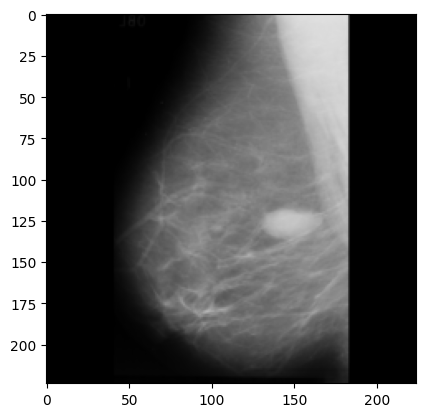

In [44]:
plt.imshow(train_set[10] / 255)

In [45]:
# !pip install tf_clahe
from IPython.display import clear_output
clear_output(wait=False)

[23. 23.]


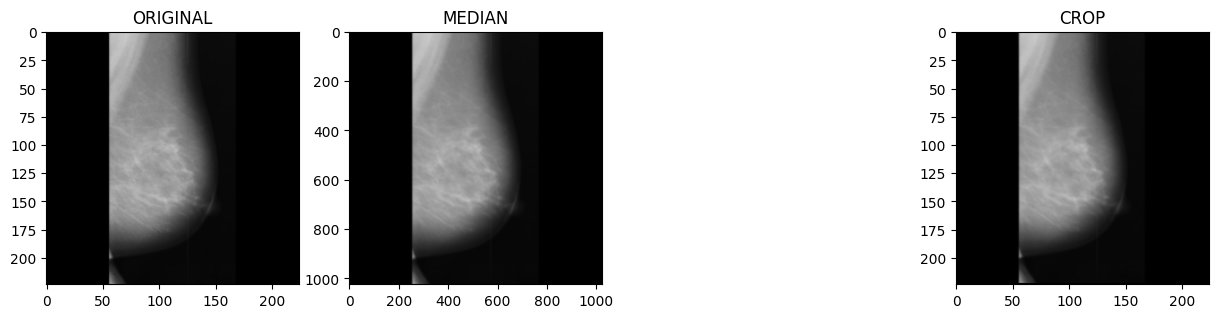

In [46]:
new = tf.convert_to_tensor(train_set[79,:,:,0])
new = tf.reshape(new,[224,224,1])
new.shape
new_rgb = tf.image.grayscale_to_rgb(new)

# plt.imshow(new_rgb/255)
new_resize = tf.image.resize_with_pad(new_rgb,1024,1024)
# # plt.imshow(new_resize/255)
import tensorflow_addons as tfa

new_median = tfa.image.median_filter2d(new_resize)

# #CLAHE Preprocessing

# import tf_clahe
# new_clahe = tf_clahe.clahe(new_median)
new_clahe=new_median
x = 573
y = 547
r = 48
# Height = y-axis, Width = x-axis
# crop = tf.image.crop_to_bounding_box(new_clahe,y-2*r,x-2*r,4*r,4*r)
crop = tf.image.resize_with_pad(new_clahe,224,224)

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
plt.imshow(new_rgb / 255)
plt.title("ORIGINAL")
plt.subplot(1,4,2)
plt.imshow(new_median / 255)
plt.title("MEDIAN")
# plt.subplot(1,4,3)
# plt.imshow(new_clahe / 255)
# plt.title("CLAHE")
plt.subplot(1,4,4)
plt.imshow(crop / 255)
plt.title("CROP")



print(train_label[79])

In [47]:
# plt.figure(figsize=(10, 10))
# first_image = crop
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#   plt.imshow(augmented_image[0] / 255)
#   plt.axis('off')

In [48]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((0,0.1)),
])
import albumentations
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate,RandomBrightnessContrast
)
from PIL  import Image
img_size = 224
# from tensorflow.keras.utils import load_img
transforms = Compose([
            Rotate(limit=30),
            HorizontalFlip(p=0.5),
        ])
train_set_new = numpy.zeros((len(train_set)*4,img_size,img_size,3))
train_label_new = numpy.zeros((len(train_label)*4,3))
# test_set_new = numpy.zeros((len(test_set)*4,img_size,img_size,3))
i=0
for x in train_set:
  image = train_set[i]
  train_set_new[4*i] = train_set[i]
  train_set_new[4*i+1] = transforms(image = image)['image']
  train_set_new[4*i+2] = transforms(image = image)['image']
  train_set_new[4*i+3] = transforms(image = image)['image']
  # train_label_new[4*i:4*i+4] = (train_label[i])
  i+=1
# train_label_new = train_label.repeat(4,0)
# train_label_new
# i=0
# for y in test_set:
#   image = test_set[i]
#   test_set_new[4*i] = test_set[i]
#   test_set_new[4*i+1] = transforms(image = image)['image']
#   test_set_new[4*i+2] = transforms(image = image)['image']
#   test_set_new[4*i+3] = transforms(image = image)['image']
#   i+=1

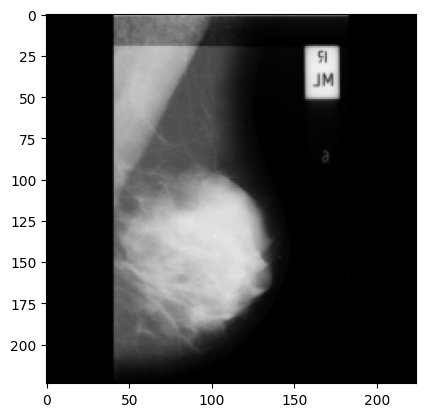

In [49]:
# test_set.shape
plt.imshow(train_set_new[7] / 255)

In [50]:
train_label_new.shape

(320, 3)

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_set_new, train_label_new))
test_dataset = tf.data.Dataset.from_tensor_slices((test_set, test_label))
BATCH_SIZE = 50
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
# del train_label, test_label, AUTOTUNE, BATCH_SIZE, train_set_new, test_set_new

In [52]:

# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0,:256,:256,0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0])
#     plt.axis('off')
# del augmented_image
train_set_new.shape

(320, 224, 224, 3)

In [53]:
preprocessing = tf.keras.applications.vgg16.preprocess_input

In [54]:
pre_trained = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
# Freeze all the layers except the last 2 layers
for layer in pre_trained.layers[:-4]:
    layer.trainable = False

In [55]:
tfinput = Input(shape=(224,224,3) )
print(tfinput)
# x = data_augmentation(tfinput)
x = preprocessing(tfinput)
print(x)
x=pre_trained(x,training=True)
print(x)
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
print(x)
x = Dropout(0.8)(x)
print(x)
output = Dense(2, activation="relu")(x)
model = Model(tfinput,output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), name='tf.nn.bias_add_1/BiasAdd:0', description="created by layer 'tf.nn.bias_add_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='vgg16/block5_pool/MaxPool:0', description="created by layer 'vgg16'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='dense_2/Relu:0', description="created by layer 'dense_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='dropout_1/Identity:0', description="created by layer 'dropout_1'")


In [58]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2569

In [59]:
history = model.fit(train_dataset
                    ,epochs=50
                    ,validation_data=test_dataset
                    # ,callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
                    )

Epoch 1/50


ValueError: in user code:

    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/jj/miniconda3/envs/wsl_tf/lib/python3.9/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 2) are incompatible


In [ ]:
fine_tune_epochs = 100
initial_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Epoch 50/150
7/7 [==============================] - 1s 102ms/step - loss: 1578856192.0000 - accuracy: 0.5031 - val_loss: 1151952256.0000 - val_accuracy: 1.0000
Epoch 51/150
7/7 [==============================] - 1s 102ms/step - loss: 1546382976.0000 - accuracy: 0.4844 - val_loss: 1275458176.0000 - val_accuracy: 1.0000
Epoch 52/150
7/7 [==============================] - 1s 102ms/step - loss: 1839214336.0000 - accuracy: 0.4719 - val_loss: 1408542080.0000 - val_accuracy: 1.0000
Epoch 53/150
7/7 [==============================] - 1s 101ms/step - loss: 1967554176.0000 - accuracy: 0.4594 - val_loss: 1552451328.0000 - val_accuracy: 1.0000
Epoch 54/150
7/7 [==============================] - 1s 102ms/step - loss: 2249734144.0000 - accuracy: 0.4875 - val_loss: 1709158144.0000 - val_accuracy: 1.0000
Epoch 55/150
7/7 [==============================] - 1s 101ms/step - loss: 2325503488.0000 - accuracy: 0.4719 - val_loss: 1878903552.0000 - val_accuracy: 1.0000
Epoch 56/150
7/7 [======================

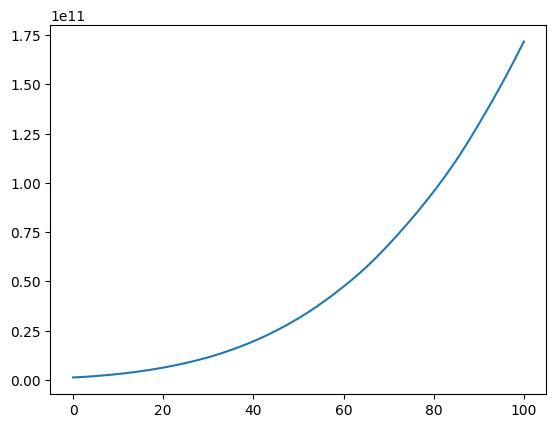

In [ ]:
Accuracy = history_fine.history['val_loss']
plt.plot(Accuracy)
plt.show()